### This Python notebook should sreve as an example of how to use tint
First import all modules that are needed

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tint import RunDirectory
import warnings
import pandas as pd
from pathlib import Path
import xarray as xr
warnings.filterwarnings("ignore")

### Define some important variables

In [2]:
trackdir = Path('.') / 'tracks' #Output directory
first = '2006-11-16 03:00' #Start-date
last = '2006-11-16 11:00' #End-date

The application of the tracking algorithm constists of the following steps:
    1. read data and meta-data (from netCDF data)
    2. apply the tracking and save the ouput to a pandas-dataframe
    3. animate the tracking output

## The tuning parameters

The parameters play an important role when the tracking is applied to different datatypes (e.g satellite data).
The algorithm offers the following tunable parameters:


* FIELD_THRESH : The threshold used for object detection. Detected objects are connnected pixels above this threshold.
    
* ISO_THRESH : Used in isolated cell classification. Isolated cells must not be connected to any other cell by contiguous pixels above this threshold.
    
* ISO_SMOOTH : Gaussian smoothing parameter in peak detection preprocessing. See
    single_max in tint.objects.
* MIN_SIZE : The minimum size threshold in pixels for an object to be detected.
* SEARCH_MARGIN : The radius of the search box around the predicted object center.
* FLOW_MARGIN : The margin size around the object extent on which to perform phase correlation.
* MAX_DISPARITY : Maximum allowable disparity value. Larger disparity values are sent to LARGE_NUM.
* MAX_FLOW_MAG : Maximum allowable global shift magnitude.
* MAX_SHIFT_DISP :Maximum magnitude of difference in meters per second for two shifts to be
    considered in agreement.


## Applying the tracking without reading the data first.
If the datasets are stored in netCDF files and do not need pre-processing you can use the `.open_dataset` method
to open the datafiles. The datafiles can be either represented by a glob pattern, like in the example below or a list of file names:

In [3]:
RD = RunDirectory.open_dataset('data/CPOL*.nc', 'radar_estimated_rain_rate',
                  start=first,
                  end=last, 
                  lon_name='longitude',
                  lat_name='latitude')
suffix = '%s-%s'%(RD.start.strftime('%Y_%m_%d_%H'),
                  RD.end.strftime('%Y_%m_%d_%H'))
RD.params['MIN_SIZE'] = 4
RD.params['FIELD_THRESH'] = 1
track_file = trackdir / f'tint_tracks_{suffix}.h5'
ncells = RD.get_tracks()
# ncells is an integer representing the number of cells that were found

Writing tracks for scan 48    

time elapsed 0.1 minutes


### Accessing the tracking data
 the tracks are saved in a dataframe and can be accessed by the ```.tracks``` instance:

In [4]:
RD.tracks.head(20)

time   grid_x  grid_y       lon      lat  area  \
scan uid                                                                 
0    0   2006-11-16 03:00:00    6.471  44.529  129.8468 -12.5388    17   
     1   2006-11-16 03:00:00    1.778  49.333  129.7551 -12.4485     9   
     2   2006-11-16 03:00:00  104.500  50.800  132.1034 -12.4045    10   
     3   2006-11-16 03:00:00   91.500  53.000  131.8270 -12.3605     6   
     4   2006-11-16 03:00:00   73.250  54.750  131.3896 -12.3164     4   
     5   2006-11-16 03:00:00   35.844  82.125  130.5393 -11.7091    96   
     6   2006-11-16 03:00:00   28.143  91.381  130.3561 -11.5064    21   
     7   2006-11-16 03:00:00   36.333  90.833  130.5397 -11.5068     6   
1    8   2006-11-16 03:10:00  104.909  50.636  132.1264 -12.4044    11   
     9   2006-11-16 03:10:00  108.800  50.600  132.2185 -12.4040     5   
     10  2006-11-16 03:10:00   95.500  52.000  131.9191 -12.3827     6   
     11  2006-11-16 03:10:00   76.714  53.000  131.4818 -12.3612     7   
     12  2006-11-16 03:10:00   88.000  52.714  131.7349 -12.3607     7   
     13  2006-11-16 03:10:00   73.000  55.000  131.3896 -12.3164     7   
     5   2006-11-16 03:10:00   72.650  86.600  131.3887 -11.5969    40   
     14  2006-11-16 03:10:00   78.071  92.571  131.5032 -11.4619    14   
     15  2006-11-16 03:10:00   97.500  95.000  131.9619 -11.4158     4   
     16  2006-11-16 03:10:00   91.500  98.125  131.8241 -11.3488     8   
2    17  2006-11-16 03:20:00  113.800  47.700  132.3339 -12.4710    10   
     18  2006-11-16 03:20:00   99.500  48.500  132.0116 -12.4723     4   

                max      mean  isolated  
scan uid                                 
0    0     1.451491  1.227551     False  
     1     1.398994  1.174826     False  
     2     5.279258  3.048147     False  
     3     3.560659  2.421517     False  
     4     2.505264  2.042082     False  
     5    31.694477  9.116140     False  
     6    28.975254  8.472269     False  
     7    10.012076  5.809241     False  
1    8     5.217285  3.262669     False  
     9     1.721878  1.453328     False  
     10    3.727539  2.343086     False  
     11    9.706904  3.791519     False  
     12    4.187761  2.103100     False  
     13   10.321914  4.560273     False  
     5    32.242092  9.384638     False  
     14   13.510443  6.020382     False  
     15    2.591437  2.371529     False  
     16    5.032235  2.767307     False  
2    17    5.353242  3.407234     False  
     18    1.403970  1.189312     False

### Saving the tracks for later analysis:
we can use pandas to save the track data and do a more in depth analysis on the storm systems later. The data can then also be loaded using pandas.

In [5]:
RD.tracks.to_hdf('/tmp/tint_tracks_%s.h5'%suffix, 'tracks')
table = pd.read_hdf('/tmp/tint_tracks_%s.h5'%suffix, 'tracks')
table.head()

time   grid_x  grid_y       lon      lat  area  \
scan uid                                                                 
0    0   2006-11-16 03:00:00    6.471  44.529  129.8468 -12.5388    17   
     1   2006-11-16 03:00:00    1.778  49.333  129.7551 -12.4485     9   
     2   2006-11-16 03:00:00  104.500  50.800  132.1034 -12.4045    10   
     3   2006-11-16 03:00:00   91.500  53.000  131.8270 -12.3605     6   
     4   2006-11-16 03:00:00   73.250  54.750  131.3896 -12.3164     4   

               max      mean  isolated  
scan uid                                
0    0    1.451491  1.227551     False  
     1    1.398994  1.174826     False  
     2    5.279258  3.048147     False  
     3    3.560659  2.421517     False  
     4    2.505264  2.042082     False

### Visualise the tracking output
The storm tracks can be visualised using either the `.animate` or `.plot_tracks` method

Animating 49 frames
Frame: 48       

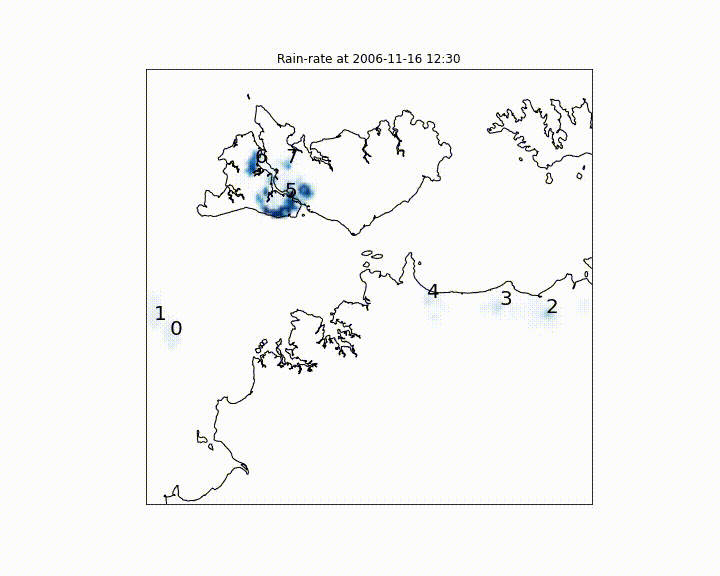

In [6]:
RD.animate(trackdir / 'ani' / f'radar_tracks_{suffix}.mp4',
           overwrite=True, dt=9.5, tracers=True, basemap_res='f', embed_gif=True)

 Create a trace plot of the individually tracked objects

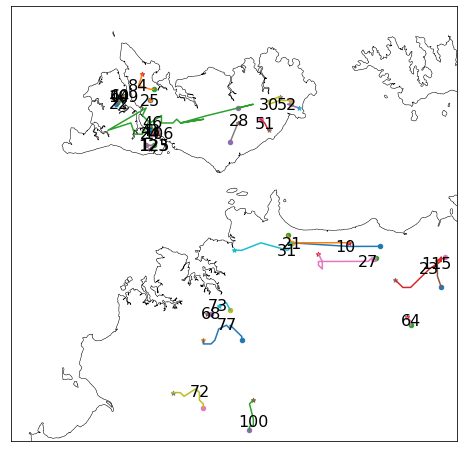

In [7]:
ax = RD.plot_traj(basemap_res='f', label=True, size=20)

## Applying the tracking with a dataset that has already been read

Sometimes data needs to be processed first. For example if derived variables like (density potential temperature) are applied to the tracking, or data needs to be remapped first. In this scenario you would create the netCDF dataset yourself, rather then letting the code load the data, and apply the tracking on the dataset. Below is an example:

In [8]:
# Read satellite based rainfall estimates and select a sub region.
files = [str(f) for f in Path('data').rglob('CMORPH*.nc')]
# Select a box around the Maritime Continent
dset = xr.open_mfdataset(sorted(files), combine='by_coords').sel(lon=slice(100, 160), lat=slice(-13, 13))
dset

<xarray.Dataset>
Dimensions:      (lat: 357, lon: 825, nv: 2, time: 48)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-25 ... 2020-01-25T23:30:00
  * lat          (lat) float64 -12.95 -12.88 -12.81 -12.73 ... 12.81 12.88 12.95
  * lon          (lon) float64 100.0 100.1 100.1 100.2 ... 159.8 159.9 160.0
Dimensions without coordinates: nv
Data variables:
    time_bounds  (time, nv) datetime64[ns] dask.array<chunksize=(2, 2), meta=np.ndarray>
    lat_bounds   (time, lat, nv) float64 dask.array<chunksize=(2, 357, 2), meta=np.ndarray>
    lon_bounds   (time, lon, nv) float64 dask.array<chunksize=(2, 825, 2), meta=np.ndarray>
    cmorph       (time, lat, lon) float32 dask.array<chunksize=(2, 357, 825), meta=np.ndarray>
Attributes: (12/57)
    ncei_template_version:      NCEI_NetCDF_Grid_template_V2.0
    title:                      NOAA Climate Data Record (CDR) of CPC Morphin...
    keywords:                   Precipitation, Satellite, High-Resolution, Gl...
    summary:                    The CMORPH CDR is a reprocessed and bias-corr...
    references:                 Xie, P., et al. (2017), Reprocessed, Bias-Cor...
    Conventions:                CF-1.6, ACDD-1.3
    ...                         ...
    geospatial_lat_resolution:  0.072771376
    geospatial_lat_units:       degrees_north
    geospatial_lon_min:         0.0
    geospatial_lon_max:         360.0
    geospatial_lon_resolution:  0.072756669
    geospatial_lon_units:       degrees_east

In [9]:
RD = RunDirectory('cmorph', dset.isel(time=slice(0, 20)), 
                  dset.lon,
                  dset.lat)
RD.params['MIN_SIZE'] = 8
RD.params['FIELD_THRESH'] = 3
RD.params['ISO_THRESH'] = 10
RD.params['ISO_SMOOTH'] = 10
RD.params['SEARCH_MARGIN'] = 8750
RD.params['FLOW_MARGIN'] = 1750
RD.params['MAX_DISPARITY'] = 999
RD.params['MAX_FLOW_MAG ']= 5000
RD.params['MAX_SHIFT_DISP'] = 1000
suffix = '%s-%s'%(RD.start.strftime('%Y_%m_%d_%H'),
                  RD.end.strftime('%Y_%m_%d_%H'))
track_file = trackdir / f'cmorph_tracks_{suffix}.h5'
ncells = RD.get_tracks()

Writing tracks for scan 19 

time elapsed 0.5 minutes


In [10]:
RD.tracks.head()

time   grid_x  grid_y       lon      lat  area   max      mean  \
scan uid                                                                        
0    0   2020-01-25  623.304   2.087  145.3314 -12.8078    23  5.07  4.811738   
     1   2020-01-25  819.826  13.765  159.6645 -11.9345   115  6.40  4.352870   
     2   2020-01-25  620.889  22.111  145.1859 -11.3523     9  3.41  3.383333   
     3   2020-01-25  617.827  29.442  144.9677 -10.8429    52  5.61  4.107116   
     4   2020-01-25  594.500  48.400  143.2215  -9.4603    10  3.68  3.420000   

          isolated  
scan uid            
0    0       False  
     1       False  
     2       False  
     3       False  
     4       False

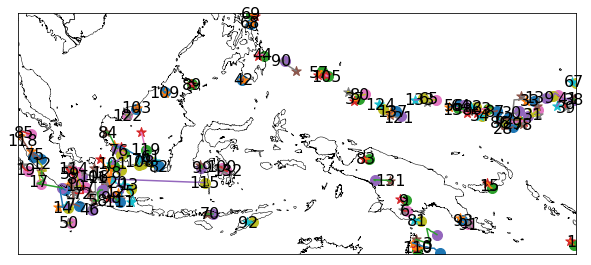

In [11]:
ax = RD.plot_traj(basemap_res='i', label=True, size=100, mintrace=5)

Animating 20 frames
Frame: 19       

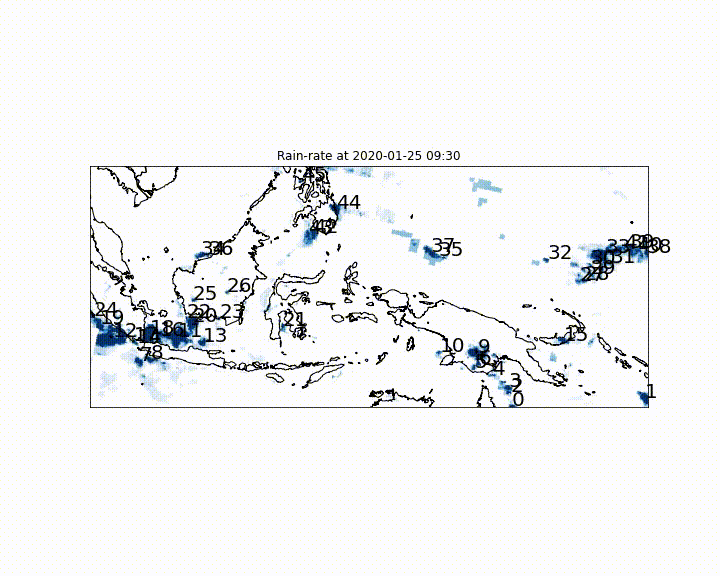

In [12]:
RD.animate(trackdir / 'ani' / f'sat_tracks_{suffix}.mp4', vmax=3,
           overwrite=True, dt=9.5, tracers=True, basemap_res='i', embed_gif=True)